In [23]:
# load required libraries and helper functions
source('/Users/abhilashdhal/Desktop/TOPOSCORE/TOPOSCORE/tp_helper.R')

## 1. Discovery analysis set ----
log_msg('####### Discovery analysis set #########')
clin_disc <- load_clin(cohort = 'Disc')
met4_disc <- load_microbiome(clin_disc)

### 1.1 CoxPH screen (except Akkermansia) ----
res_surv <- load_or_compute('res_surv2.rds',
                          screen_surv_met4(clin_disc, met4_disc, type = 'OS'))

# Select species based on HR thresholds mentioned in the paper
res_surv_filt <- res_surv %>% 
  dplyr::filter(HR <= 0.80 | HR >= 1.25)

selected_species <- res_surv_filt$SPECIES
log_msg('%d/%d species selected', length(selected_species), nrow(res_surv))

met4_disc_filt <- met4_disc[, c('Sample_id', selected_species)]
hr_annots <- res_surv_filt %>% 
  dplyr::mutate(HRCAT = ifelse(HR < 1, 'R', 'NR')) %>% 
  dplyr::select(HRCAT, SPECIES)


Data source directory: /Users/abhilashdhal/Desktop/TOPOSCORE/TOPOSCORE

All expected input files found

####### Discovery analysis set #########

Reading 245 clinical data records from cohort Disc

Reading 245 microbiome data records

Removed 560 columns starting with "GGB"

Kept 591/1219 species with prevalence >= 2.5%

Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  1 ; coefficient may be infinite. ”
Results saved to file res_surv2.rds

286/591 species selected



## Sum abundances of met4_disc

In [25]:
rowSums(met4_disc[, -1]) %>% 
  data.frame() %>% 
  setNames("SUM_Abundance") %>%
  mutate(Sample_id = met4_disc$Sample_id) %>%
  arrange(desc(SUM_Abundance)) -> met4_SumSample

View(met4_SumSample)

SUM_Abundance,Sample_id
<dbl>,<chr>
99.99279,LUM_217
99.78683,LUM3_246
99.38305,LUM2_061
99.33526,PD1p_018
99.21898,LUM_270
98.97346,LUM2_069
98.95968,LUM2_037
98.94920,LUM_09
98.87278,LUM2_062


In [26]:
### 1.2 Correlation screen ----
res <- load_or_compute('res_pairs2.rds', screen_pairs(met4_disc_filt))
# filter based on Fisher Bonferroni-corrected p-values <= 0.05
res_filt <- load_or_compute('res_pairs_filt2.rds', {
  min_p <- bind_rows(list(
    res %>% dplyr::select(VAR = VAR1, FISHER_P),
    res %>% dplyr::select(VAR = VAR2, FISHER_P)
  )) %>% 
    dplyr::group_by(VAR) %>% 
    dplyr::summarize(MIN_P = min(FISHER_P)) %>% 
    dplyr::arrange(-MIN_P)
  sp2 <- min_p[min_p$MIN_P <= 0.05 / nrow(min_p), 'VAR', drop = TRUE]
  res %>% 
    dplyr::filter(VAR1 %in% sp2 & VAR2 %in% sp2)
})
log_msg('Keeping %d pairs (%d species)', nrow(res_filt), 
        length(unique(c(res_filt$VAR1, res_filt$VAR2))))

Results saved to file res_pairs2.rds

Results saved to file res_pairs_filt2.rds

Keeping 19503 pairs (198 species)



In [27]:
res_surv_filt

HR,HR_LCI,HR_UCI,P,SPECIES,MEDIAN
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
4.6943558,2.3415654,9.4112154,1.315645e-05,Actinomyces_graevenitzii,NA
5.3678236,2.3198061,12.4206634,8.641579e-05,Actinomyces_sp_ICM58,NA
4.7726611,2.0856737,10.9213123,2.152602e-04,Lactonifactor_sp_BIOML_A6,NA
0.5716084,0.4188074,0.7801586,4.245982e-04,Clostridiales_bacterium_KLE1615,0.02738
1.7451958,1.2783703,2.3824930,4.544080e-04,Enterocloster_aldensis,0.00305
1.9918888,1.3295467,2.9841909,8.348095e-04,Streptococcus_anginosus,NA
0.5911319,0.4329737,0.8070627,9.353638e-04,Anaerobutyricum_hallii,0.04088
0.5820125,0.4223818,0.8019724,9.357783e-04,Eubacterium_ventriosum,NA
3.2190586,1.5669814,6.6129300,1.458905e-03,Rhodobacteraceae_unclassified_SGB53807,NA


Clustering 198 markers in 7 clusters (ward.D2 / manhattan)



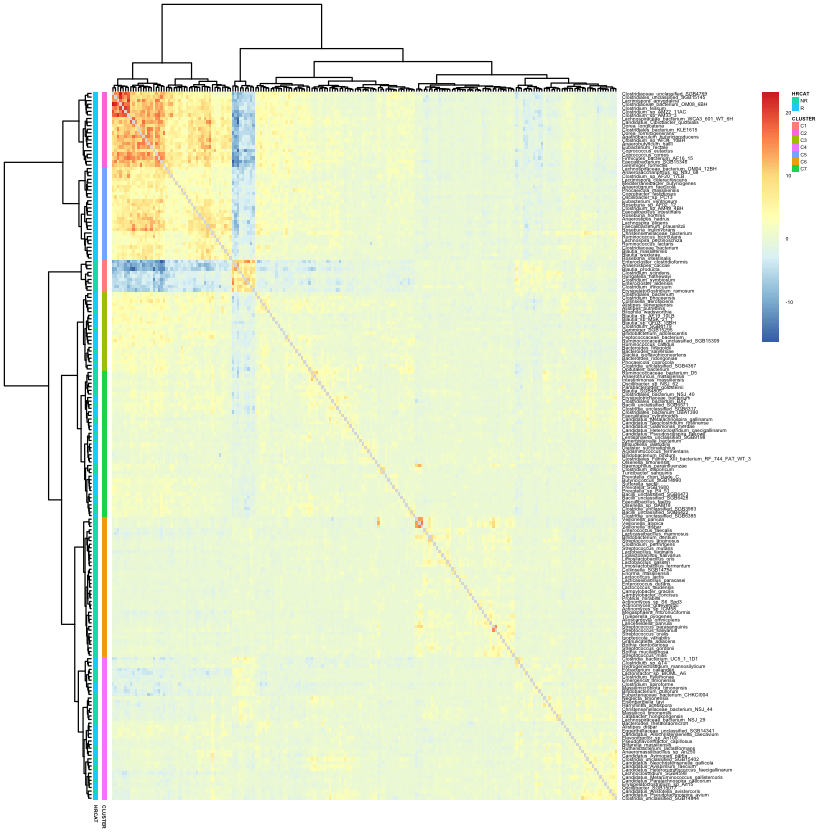

In [28]:
### 1.3 Clustering ----
SCORE <- 'fisher_p'
METHOD <- 'ward.D2'
DISTANCE <- 'manhattan'
cc <- cluster_species(res_filt, score = SCORE, method = METHOD, distance = DISTANCE, k = 7) %>% 
  renumber_clusters()
plt_fisher_disc <- plot_score_matrix(
  res_filt, 
  score = SCORE, 
  method = METHOD, 
  distance = DISTANCE, 
  annots = list(cc, hr_annots), 
  fontsize = 3)

ggsave(plt_fisher_disc, filename = 'fig_fisher_disc.pdf', width = 30, height = 20, units = "cm")

In [29]:

### 1.4 Definition of SIGB groups ----
cc_names <- unique(cc$CLUSTER)
cc_species <- setNames(lapply(cc_names, function(x) cc[cc$CLUSTER == x, 'SPECIES', drop = TRUE]), cc_names)

# Define SIGB1 (C5 and C6) with HR >= 1.25
SIGB1 <- c(cc_species$C5, cc_species$C6)
SIGB1 <- SIGB1[SIGB1 %in% res_surv_filt$SPECIES[res_surv_filt$HR >= 1.25]]

# Define SIGB2 (C1, C2, and C3) with HR <= 0.80
SIGB2 <- c(cc_species$C1, cc_species$C2, cc_species$C3)
SIGB2 <- SIGB2[SIGB2 %in% res_surv_filt$SPECIES[res_surv_filt$HR <= 0.80]]

# Log the counts
log_msg('SIGB1 (C5 and C6, HR >= 1.25) contains %d species', length(SIGB1))
log_msg('SIGB2 (C1, C2, and C3, HR <= 0.80) contains %d species', length(SIGB2))

# Save the SIGB groups
save(SIGB1, file = 'sigb1.rds')
save(SIGB2, file = 'sigb2.rds')



SIGB1 (C5 and C6, HR >= 1.25) contains 39 species

SIGB2 (C1, C2, and C3, HR <= 0.80) contains 38 species



Setting levels: control = 0, case = 1

Setting direction: controls < cases

ROC AUC = 0.60 [0.67 - 0.74]

Cut-off thresholds = 0.5849 and 0.7390



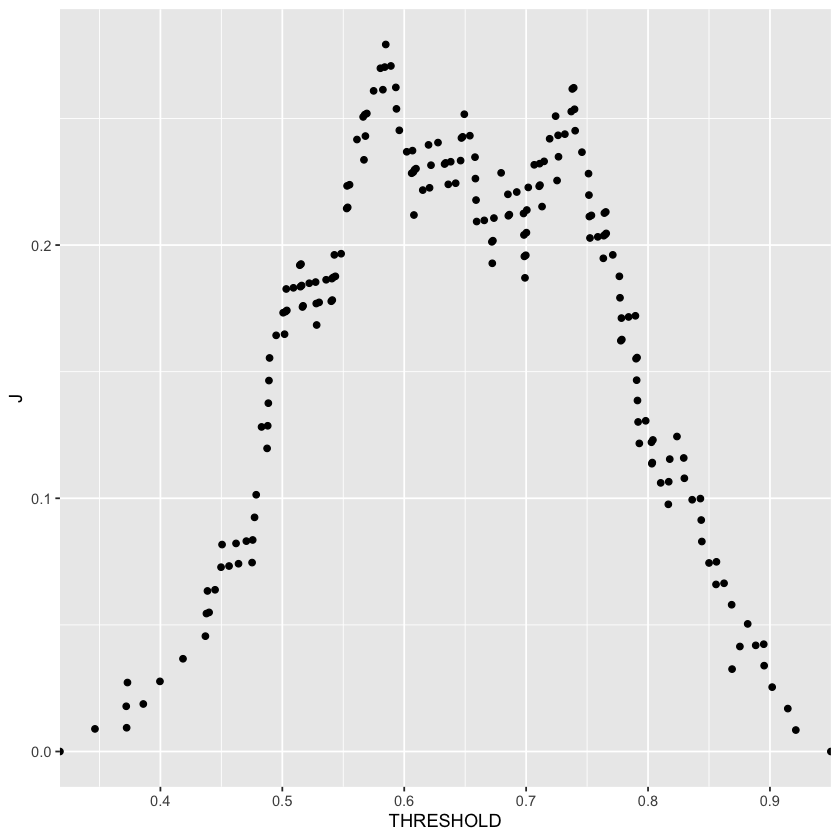

In [42]:
### 1.5 Toposcoring ----
scores_disc <- compute_toposcore(met4_disc, sigb1 = SIGB1, sigb2 = SIGB2)
pred_disc <- clin_disc %>% 
  dplyr::left_join(scores_disc, by = 'Sample_id') %>% 
  dplyr::filter(OS12 != '') %>% 
  dplyr::mutate(OS12 = factor(OS12, levels = c('NR', 'R')))
roc <- calc_roc(pred_disc$OS12, pred_disc$TOPOB01, verbose = TRUE)
log_msg('ROC AUC = %.2f [%.2f - %.2f]', roc$AUC[1], roc$AUC[2], roc$AUC[3])
youden <- roc$ROC_DF %>% mutate(SENS = TPR, SPEC = 1 - FPR) %>% mutate(J = SENS + SPEC - 1)
ggplot(youden, aes(x = THRESHOLD, y = J)) + geom_point()
ycut_nr <- youden[which.max(youden$J), ] # 0.5351351
ycut_r <- youden[which(youden$THRESHOLD > 0.7 & youden$J > 0.23), ] # 0.7911411
ycut_r <- ycut_r[which.max(ycut_r$J), ]
log_msg('Cut-off thresholds = %.4f and %.4f', ycut_nr$THRESHOLD, ycut_r$THRESHOLD)
plt_roc <- plot_roc(roc$ROC_DF) + 
  geom_point(data = ycut_nr, color = 'red') +
  geom_point(data = ycut_r, color = 'green')
ggsave(plt_roc, filename = 'fig_roc.pdf', width = 10, height = 10, units = "cm")
plt_kde_disc <- plot_toposcoreb01_density(
  scores_disc, 
  clin_disc, 
  lims = c(ycut_r$THRESHOLD, ycut_nr$THRESHOLD))
ggsave(plt_kde_disc, filename = 'fig_kde_disc.pdf', width = 10, height = 10, units = "cm")